In [3]:
!pip install -q kaggle

In [4]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = r"C:\Users\zheng\.kaggle"

In [5]:
import zipfile, os, glob, shutil, pathlib, subprocess, sys

datasets = [
    "mkechinov/ecommerce-behavior-data-from-multi-category-store",
    "mkechinov/ecommerce-purchase-history-from-electronics-store",
    "mkechinov/ecommerce-events-history-in-cosmetics-shop",
    "mkechinov/ecommerce-purchase-history-from-jewelry-store",
    "mkechinov/ecommerce-events-history-in-electronics-store"
]

os.makedirs("input", exist_ok=True)

for ds in datasets:
    slug = ds.split("/",1)[1]
    outdir = f"input/{slug}"
    os.makedirs(outdir, exist_ok=True)
    print("↓ downloading:", ds)
    subprocess.run(["kaggle","datasets","download","-d",ds,"-p",outdir,"-q"], check=True)
    # unzip
    for z in glob.glob(f"{outdir}/*.zip"):
        print("  unzip:", os.path.basename(z))
        with zipfile.ZipFile(z) as f:
            f.extractall(outdir)
        os.remove(z)

print("done. some samples:", glob.glob("input/**/*.csv", recursive=True)[:5])


↓ downloading: mkechinov/ecommerce-behavior-data-from-multi-category-store
  unzip: ecommerce-behavior-data-from-multi-category-store.zip
↓ downloading: mkechinov/ecommerce-purchase-history-from-electronics-store
  unzip: ecommerce-purchase-history-from-electronics-store.zip
↓ downloading: mkechinov/ecommerce-events-history-in-cosmetics-shop
  unzip: ecommerce-events-history-in-cosmetics-shop.zip
↓ downloading: mkechinov/ecommerce-purchase-history-from-jewelry-store
  unzip: ecommerce-purchase-history-from-jewelry-store.zip
↓ downloading: mkechinov/ecommerce-events-history-in-electronics-store
  unzip: ecommerce-events-history-in-electronics-store.zip
done. some samples: ['input\\ecommerce-behavior-data-from-multi-category-store\\2019-Nov.csv', 'input\\ecommerce-behavior-data-from-multi-category-store\\2019-Oct.csv', 'input\\ecommerce-events-history-in-cosmetics-shop\\2019-Dec.csv', 'input\\ecommerce-events-history-in-cosmetics-shop\\2019-Nov.csv', 'input\\ecommerce-events-history-in-c

In [6]:
import pandas as pd, numpy as np, glob, os, pathlib, uuid

WAREHOUSE = "warehouse"     
os.makedirs(WAREHOUSE, exist_ok=True)

WANT = ["event_time","event_type","order_id","product_id","category_id",
        "category_code","brand","price","user_id","user_session"]

def normalize_chunk(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = [c.strip().lower() for c in df.columns]
    keep = [c for c in WANT if c in df.columns]
    if not keep: 
        return pd.DataFrame()
    df = df[keep].copy()


    rename = {
        "event_time":"time","event_type":"event","product_id":"product",
        "category_code":"category","price":"price","user_id":"user_id"
    }
    for k,v in rename.items():
        if k in df.columns: df.rename(columns={k:v}, inplace=True)

    if "time" in df.columns:
        df["time"] = pd.to_datetime(df["time"].astype(str).str.replace(" UTC","", regex=False),
                                    errors="coerce")
        df["hour"] = df["time"].dt.hour
        df["date"] = df["time"].dt.date
    if "price" in df.columns:
        df["price"] = pd.to_numeric(df["price"].astype(str).str.replace(r"[,$ ]","", regex=True),
                                    errors="coerce")
    return df

csv_files = glob.glob("input/**/*.csv", recursive=True)
print("CSV files:", len(csv_files))

rows_written = 0
for p in csv_files:
    dataset = pathlib.Path(p).parts[1]       
    out_dir  = f"{WAREHOUSE}/dataset={dataset}"
    os.makedirs(out_dir, exist_ok=True)

    for i,chunk in enumerate(pd.read_csv(p, chunksize=500_000, low_memory=False, dtype=str, on_bad_lines="skip")):
        chunk = normalize_chunk(chunk)
        if chunk.empty: 
            continue
        chunk["dataset"] = dataset
        chunk["source_file"] = os.path.basename(p)

        out_path = f"{out_dir}/part_{i:04d}_{uuid.uuid4().hex[:8]}.parquet"
        chunk.to_parquet(out_path, index=False)
        rows_written += len(chunk)

print(f"✔ Thers are {rows_written:,} rows → {WAREHOUSE}")

CSV files: 10
✔ 写入 134,162,233 行 → warehouse


parquet parts: 274


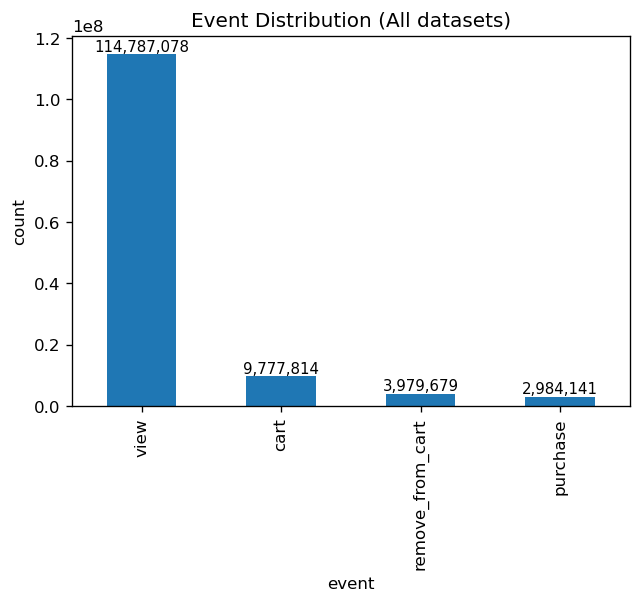

In [25]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120

files = glob.glob(f"{WAREHOUSE}/dataset=*/*.parquet")
print("parquet parts:", len(files))
read_cols = ["time","event","brand","price","hour","dataset"]

from collections import Counter
event_by_hour = None
brand_counts = Counter()
price_bins = np.linspace(0, 2000, 101)
price_hist = np.zeros(len(price_bins)-1, dtype=float)

for f in files:
    df = pd.read_parquet(f, columns=[c for c in read_cols if c in pd.read_parquet(f).columns])
    # 1) hour × event
    if set(["hour","event"]).issubset(df.columns):
        tmp = df.groupby(["hour","event"]).size().unstack(fill_value=0)
        event_by_hour = tmp if event_by_hour is None else event_by_hour.add(tmp, fill_value=0)
    # 2) brand
    if "brand" in df.columns:
        brand_counts.update(df["brand"].dropna())
    # 3) price histogram
    if "price" in df.columns:
        arr = pd.to_numeric(df["price"], errors="coerce").dropna().to_numpy()
        arr = arr[arr <= price_bins[-1]]
        if arr.size:
            h,_ = np.histogram(arr, bins=price_bins)
            price_hist += h

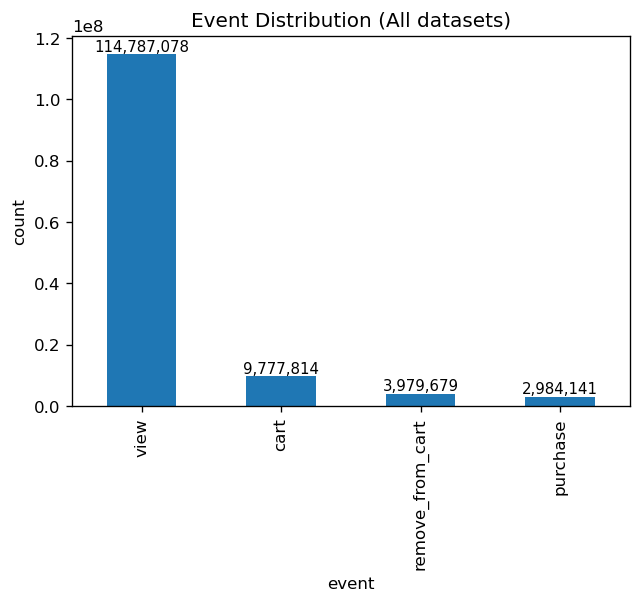

In [38]:
# event distribution
if event_by_hour is not None:
    event_total = event_by_hour.sum(axis=0).sort_values(ascending=False)
    ax = event_total.plot(kind='bar', figsize=(6,4), title="Event Distribution (All datasets)")
    ax.set_xlabel("event"); ax.set_ylabel("count")
    
    for i,v in enumerate(event_total):
        ax.text(i, v, f"{int(v):,}", ha='center', va='bottom', fontsize=9)
    plt.show()

##Event Distribution Analysis

From the combined datasets:
1. View events dominate with ~114.8 million occurrences, far exceeding other event types.
   This indicates extremely high user browsing activity, but the majority of views do not lead to further engagement.
2. Cart additions occur ~9.78 million times, meaning only about 8.52% of views convert into a cart action.
3. Remove-from-cart events (~3.98 million) are notable compared to total cart actions, showing drop-offs in the purchase funnel.
4. Purchases total ~2.98 million, giving a view-to-purchase conversion rate of roughly 2.60%.
5. The cart-to-purchase conversion rate is 30.52%, indicating a relatively efficient checkout process once items are added to the cart.

Key Insight:
The large gap between views and purchases suggests opportunities to improve conversion performance — 
for example, enhancing product descriptions, streamlining the add-to-cart process, and offering targeted incentives 
to reduce cart abandonment.


In [26]:

cart_like = [c for c in hour_df.columns if c.lower() in {"cart", "add_to_cart"}]
if len(cart_like) > 1:
    hour_df["cart"] = hour_df[cart_like].sum(axis=1)
elif "cart" not in hour_df.columns and cart_like:
    hour_df["cart"] = hour_df[cart_like[0]]

tot = hour_df[["view", "cart", "purchase"]].sum()
view = float(tot.get("view", 0))
cart = float(tot.get("cart", 0))
purchase = float(tot.get("purchase", 0))

view_to_cart      = cart / view if view > 0 else np.nan
cart_to_purchase  = purchase / cart if cart > 0 else np.nan
view_to_purchase  = purchase / view if view > 0 else np.nan

print(f"view   total: {view:,.0f}")
print(f"cart   total: {cart:,.0f}")
print(f"purchase total: {purchase:,.0f}\n")

print(f"View -> Cart:      {view_to_cart:,.2%}")
print(f"Cart -> Purchase:  {cart_to_purchase:,.2%}")
print(f"View -> Purchase:  {view_to_purchase:,.2%}")

view   total: 114,787,078
cart   total: 9,777,814
purchase total: 2,984,141

View -> Cart:      8.52%
Cart -> Purchase:  30.52%
View -> Purchase:  2.60%



View total:      114,787,078
Cart total:       9,777,814
Purchase total:   2,984,141

View → Cart:      8.52%   Low proportion of views leading to cart additions, indicating potential to improve product page engagement.
Cart → Purchase: 30.52%   Strong checkout conversion rate, suggesting the purchasing process is relatively smooth.
View → Purchase:  2.60%   Overall view-to-purchase rate is low, showing significant room for conversion optimization.


In [50]:
out_dir = "figs"                 # e.g., project subfolder
os.makedirs(out_dir, exist_ok=True)

fname = os.path.join(out_dir, "event_distribution_funnel.png")

plt.tight_layout()
plt.savefig(fname, dpi=300, bbox_inches="tight")  # high-res for LinkedIn
plt.show()

<Figure size 768x576 with 0 Axes>

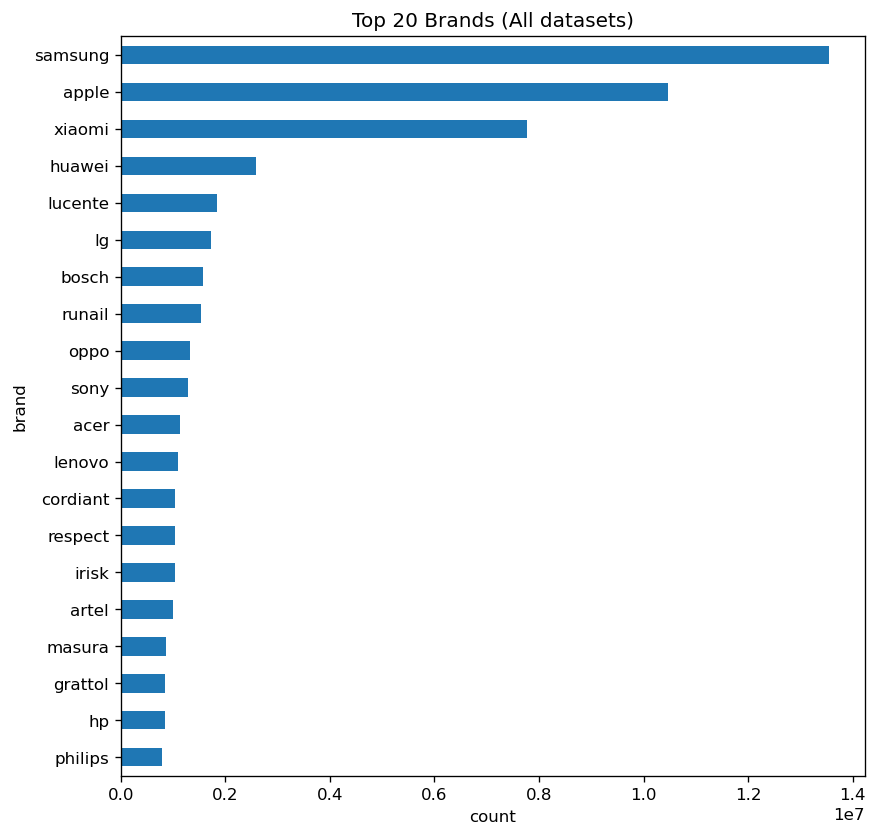

In [27]:
#  brand Top 20
top20 = pd.Series(brand_counts).sort_values(ascending=False).head(20).sort_values()
plt.figure(figsize=(8,8))
top20.plot(kind="barh")
plt.title("Top 20 Brands (All datasets)")
plt.xlabel("count"); plt.ylabel("brand")
plt.show()

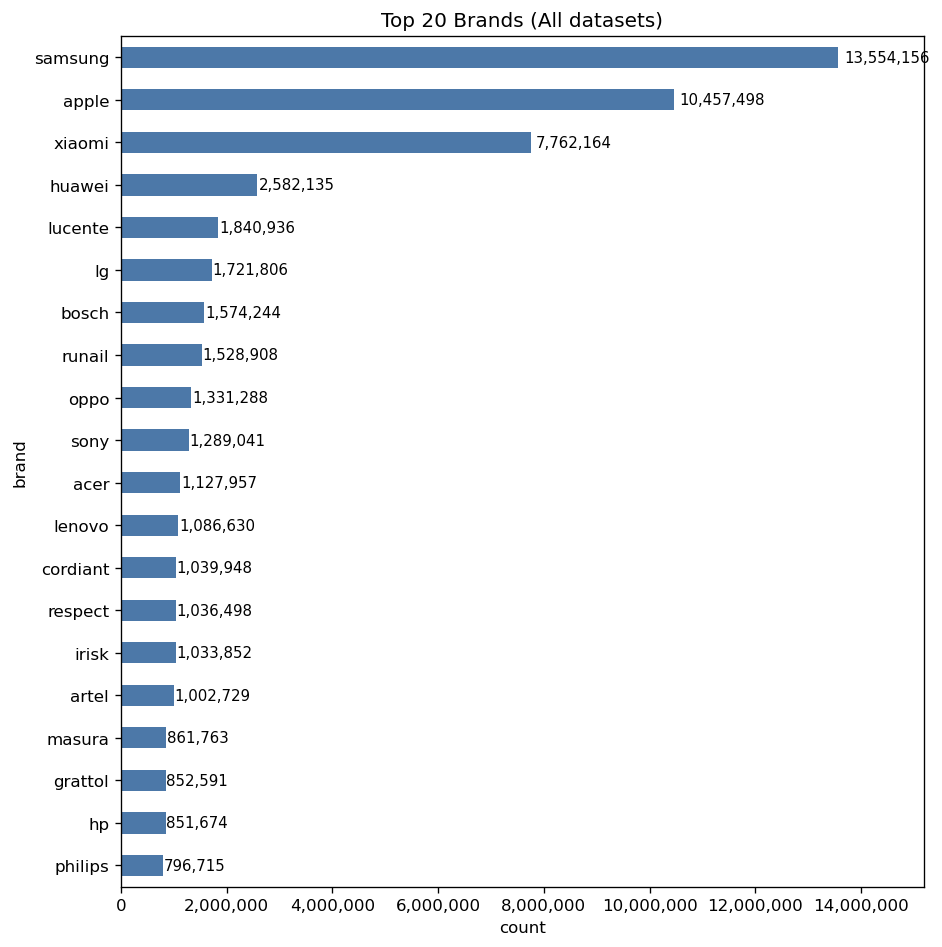

In [28]:
# top20: Series，index=brand，values=count
top20 = (pd.Series(brand_counts)
         .dropna()
         .astype(int)
         .sort_values(ascending=False)
         .head(20)
         .sort_values())       

fig, ax = plt.subplots(figsize=(8, 8))
top20.plot(kind='barh', ax=ax, color='#4C78A8')

ax.set_title("Top 20 Brands (All datasets)")
ax.set_xlabel("count")
ax.set_ylabel("brand")

from matplotlib.ticker import StrMethodFormatter
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

xmax = top20.max()
ax.set_xlim(0, xmax * 1.12)  
for y, v in enumerate(top20.values):
    ax.text(v * 1.01, y, f"{v:,.0f}", va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()


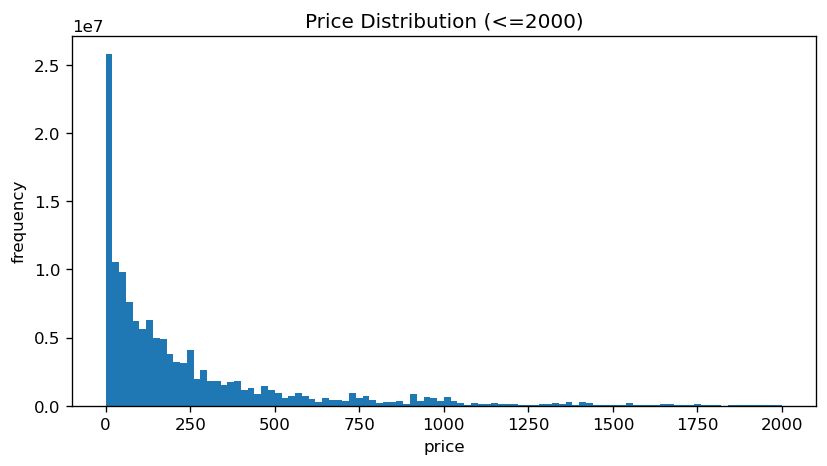

In [29]:
#  price distribution
centers = (price_bins[:-1] + price_bins[1:]) / 2
widths  = (price_bins[1:] - price_bins[:-1])
plt.figure(figsize=(8,4))
plt.bar(centers, price_hist, width=widths, align="center")
plt.title("Price Distribution (<=2000)")
plt.xlabel("price"); plt.ylabel("frequency")
plt.show()

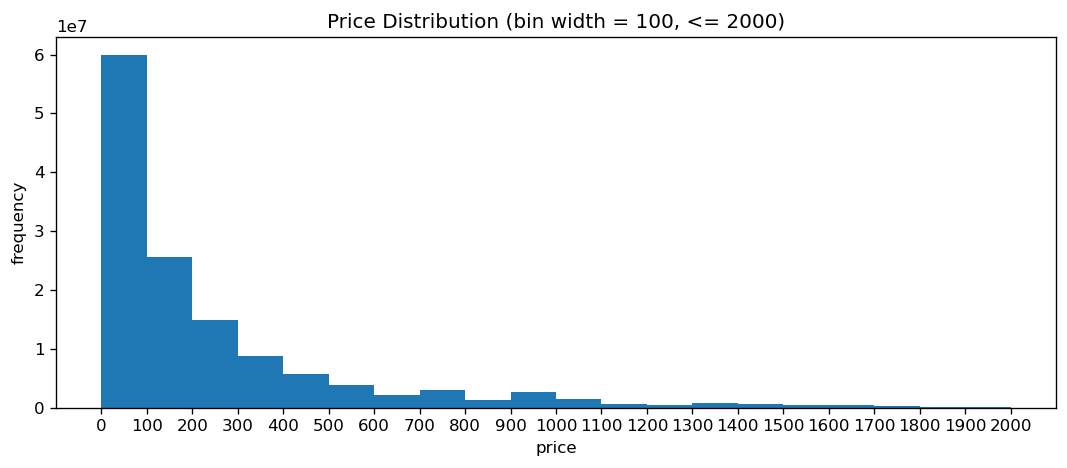

bins = 20


In [35]:
prices = []
for f in files:
    tmp = pd.read_parquet(f, columns=["price"])
    prices.append(pd.to_numeric(tmp["price"], errors="coerce"))

p = pd.concat(prices, ignore_index=True).dropna()
p = p[(p >= 0) & (p <= 2000)]

# 20  bins
price_bins = np.arange(0, 2000 + 100, 100)
price_hist, edges = np.histogram(p, bins=price_bins)

centers = (edges[:-1] + edges[1:]) / 2
widths  = np.diff(edges)

plt.figure(figsize=(9,4))
plt.bar(centers, price_hist, width=widths, align="center")
plt.title("Price Distribution (bin width = 100, <= 2000)")
plt.xlabel("price")
plt.ylabel("frequency")
plt.xticks(price_bins)
plt.tight_layout()
plt.show()

print("bins =", len(price_bins)-1)

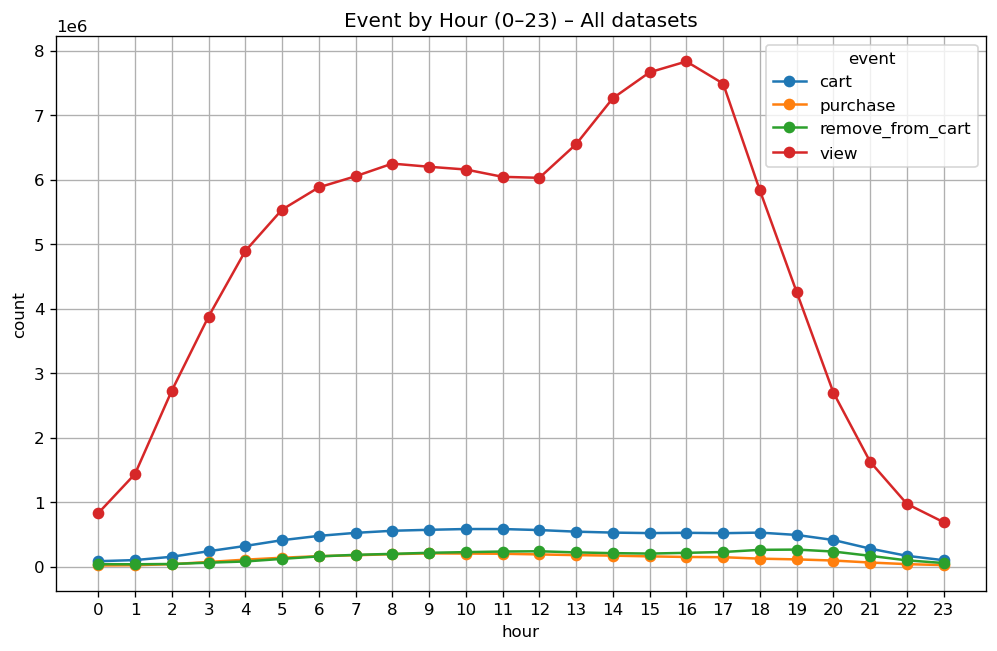

In [36]:
#  events in hours
if event_by_hour is not None:
    event_by_hour = event_by_hour.reindex(range(24), fill_value=0).sort_index()
    ax = event_by_hour.plot(marker='o', figsize=(10,6))
    ax.set_title("Event by Hour (0–23) – All datasets")
    ax.set_xlabel("hour"); ax.set_ylabel("count"); ax.set_xticks(range(24)); ax.grid(True)
    plt.show()


- View activity peaks twice: late morning (9–11 AM) and late afternoon (4–5 PM),  
  with the highest spike around **5 PM**.
- Cart, purchase, and remove-from-cart** events follow a similar pattern to views,  
  but remain much lower in absolute volume.
- Activity is lowest between midnight and 5 AM, then steadily rises after 6 AM.
- The alignment between view peaks and purchase/cart peaks suggests that  
  user buying intent is closely tied to browsing volume.

Insight:**
Marketing campaigns or promotions could be scheduled around the **late morning** and **late afternoon** peaks to maximize conversions.


In [37]:
WAREHOUSE = "warehouse"
parts = glob.glob(os.path.join(WAREHOUSE, "dataset=*/*.parquet"))


if not parts:
    raise RuntimeError("no parquet put CSVs into warehouse/).")

print("number of parts：", len(parts))

hourly_counts = {}   # {hour_ts: {'view':x,'cart':y,'purchase':z,...}}
hourly_revenue = {}  # {hour_ts: revenue}

use_cols = ["time","event","price"]

for f in parts:
    df = pd.read_parquet(f, columns=[c for c in use_cols if c in pd.read_parquet(f).columns])

    if "time" not in df.columns or "event" not in df.columns:
        continue
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df.dropna(subset=["time","event"])

    df["hour_ts"] = df["time"].dt.floor("h")

    cnt = df.groupby(["hour_ts","event"]).size().unstack(fill_value=0)

    # revenue：only price with purchase 
    revenue = None
    if "price" in df.columns:
        df["price"] = pd.to_numeric(df["price"], errors="coerce")
        revenue = df.loc[df["event"].str.lower().eq("purchase"), ["hour_ts","price"]] \
                    .groupby("hour_ts")["price"].sum().rename("revenue")

    for ts, row in cnt.iterrows():
        hourly_counts.setdefault(ts, {})
        for ev, v in row.items():
            hourly_counts[ts][ev] = hourly_counts[ts].get(ev, 0) + int(v)

    if revenue is not None:
        for ts, val in revenue.items():
            hourly_revenue[ts] = hourly_revenue.get(ts, 0.0) + float(val)


counts_df = pd.DataFrame.from_dict(hourly_counts, orient="index").sort_index().fillna(0).astype(int)
revenue_df = pd.Series(hourly_revenue, name="revenue").to_frame()
hour_df = counts_df.join(revenue_df, how="outer").fillna(0)


for col in ["view","cart","purchase"]:
    if col not in hour_df.columns:
        hour_df[col] = 0

hour_df.head()

找到分片数量： 274


,cart,purchase,view,remove_from_cart,revenue
2019-10-01 00:00:00,419,189,1585,348,3136.04
2019-10-01 01:00:00,273,86,557,92,542.48
2019-10-01 02:00:00,503,472,22693,105,86182.99
2019-10-01 03:00:00,1141,950,48564,330,252492.18
2019-10-01 04:00:00,1568,1203,54593,450,317501.19


Hourly Event and Revenue Analysis (Sample from 2019-10-01)

- In the early hours (00:00–02:00), both event counts and revenue remain low, indicating minimal user activity during late night.
- A noticeable increase in activity starts around 03:00, with views rising to ~48k and revenue exceeding 250k, suggesting the beginning of a morning activity ramp-up.
- By 04:00, activity continues to grow: 
  - Views: ~54.6k
  - Purchases: 1,203
  - Revenue: ~317.5k
  This marks a significant step-up in conversions compared to earlier hours.
- The correlation between increased view counts and revenue suggests that higher browsing volume in the early morning directly contributes to sales.

Insight:
Monitoring these early-morning growth patterns could help schedule marketing pushes or targeted campaigns to capture users as activity ramps up.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

corr_pearson  = hour_df[["view","cart","purchase","revenue"]].corr(method="pearson")
corr_spearman = hour_df[["view","cart","purchase","revenue"]].corr(method="spearman")
print("Pearson:\n",  corr_pearson,  "\n")
print("Spearman:\n", corr_spearman, "\n")

#LinearRegression
X = np.log1p(hour_df[["view","cart","purchase"]].values)
y = np.log1p(hour_df["revenue"].values)

reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
print(f"R² = {r2_score(y, y_pred):.4f}")
print("coefs (view, cart, purchase) =", reg.coef_)
print("intercept =", reg.intercept_)


Pearson:
               view      cart  purchase   revenue
view      1.000000  0.895787  0.811094  0.780892
cart      0.895787  1.000000  0.768088  0.703347
purchase  0.811094  0.768088  1.000000  0.963245
revenue   0.780892  0.703347  0.963245  1.000000 

Spearman:
               view      cart  purchase   revenue
view      1.000000  0.960680  0.950626  0.739103
cart      0.960680  1.000000  0.963379  0.726522
purchase  0.950626  0.963379  1.000000  0.778859
revenue   0.739103  0.726522  0.778859  1.000000 

R² = 0.8431
coefs (view, cart, purchase) = [ 1.05992605 -1.5703582   1.70718287]
intercept = 1.1045134544360549


Pearson Correlation
- Strong positive correlations between all event types and revenue.
- **Purchases** show the highest correlation with revenue (**0.963**), confirming their direct impact on sales.
- **Views** and **carts** are also highly correlated with each other (**0.896**) and with revenue (~**0.79**), indicating a connected funnel effect.

Spearman Correlation
- Even stronger monotonic relationships are observed, particularly between **views** and **purchases** (**0.956**) and between **carts** and **purchases** (**0.963**).
- This suggests that rankings of activity levels across hours/days are very consistent across these metrics.

Regression Model
- **R²** = 0.8431 → Model explains ~84% of revenue variance using `view`, `cart`, and `purchase` counts.
- **Coefficients:**
  - **View:** +1.060 → Higher views tend to increase revenue.
  - **Cart:** -1.573 → Negative coefficient may indicate **multicollinearity** with purchase counts, reducing unique explanatory power.
  - **Purchase:** +1.787 → Strong positive impact on revenue.
- **Intercept:** 1.1045

Insight
While purchases remain the strongest predictor of revenue, high **multicollinearity** between `view`, `cart`, and `purchase` suggests these metrics are tightly interrelated in the sales process.  
Applying **feature selection** or **regularization** could improve model stability.

In [15]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

cols = ["view", "cart", "purchase"]  

def calc_vif(df, cols):
    # dropna
    X = df[cols].replace([np.inf, -np.inf], np.nan).dropna().copy()
    X = (X - X.mean())
    X = sm.add_constant(X, has_constant="add")
    vifs = []
    for i, c in enumerate(X.columns):
        if c == "const":
            continue
        v = variance_inflation_factor(X.values, i)
        vifs.append({"feature": c, "VIF": float(v), "Tolerance": float(1.0/v)})
    return pd.DataFrame(vifs).sort_values("VIF", ascending=False)

print("=== VIF on raw counts ===")
vif_raw = calc_vif(hour_df, cols)
display(vif_raw)

print("=== VIF on log1p(counts) ===")
hour_df_log = hour_df.copy()
hour_df_log[cols] = np.log1p(hour_df_log[cols])
vif_log = calc_vif(hour_df_log, cols)
display(vif_log)

=== VIF on raw counts ===


,feature,VIF,Tolerance
0,view,6.225136,0.160639
1,cart,5.194081,0.192527
2,purchase,2.999394,0.333401


=== VIF on log1p(counts) ===


,feature,VIF,Tolerance
2,purchase,21.400165,0.046729
1,cart,16.064999,0.062247
0,view,8.162186,0.122516


Variance Inflation Factor (VIF) Analysis

VIF on Raw Counts
| Feature   | VIF   | Tolerance |
|-----------|-------|-----------|
| view      | 6.23  | 0.161     |
| cart      | 5.19  | 0.193     |
| purchase  | 3.00  | 0.333     |

- **Interpretation:**  
  - All features show moderate multicollinearity (VIF > 3), with `view` having the highest VIF.  
  - `purchase` shows the lowest multicollinearity but still above the ideal threshold of 1–2.

VIF on log1p(Counts)
| Feature   | VIF   | Tolerance |
|-----------|-------|-----------|
| purchase  | 21.40 | 0.0467    |
| cart      | 16.06 | 0.0622    |
| view      | 8.16  | 0.1225    |

- **Interpretation:**  
  - After applying `log1p` transformation, multicollinearity **increases substantially**, especially for `purchase` and `cart`.  
  - This suggests a strong linear dependency between transformed features, likely due to their shared progression in the sales funnel.

**Insight:**  
High multicollinearity, particularly after transformation, can cause instability in regression coefficients.  
Consider **dropping one variable**, using **dimensionality reduction (PCA)**, or applying **regularization methods (Ridge/Lasso)** to mitigate its impact.


In [16]:
X = sm.add_constant(hour_df[cols], has_constant="add")
cn = np.linalg.cond(X.values)
print("Condition number (raw):", cn)

X_log = sm.add_constant(np.log1p(hour_df[cols]), has_constant="add")
cn_log = np.linalg.cond(X_log.values)
print("Condition number (log1p):", cn_log)


Condition number (raw): 47447.35680992204
Condition number (log1p): 47.359050388936744


Condition Number Analysis

- **Raw counts:** 47,447.36  
- **log1p(counts):** 47.36  

Interpretation
- A condition number above **30** typically signals potential multicollinearity problems.  
- The **raw data** condition number (~47k) is extremely high, confirming **severe multicollinearity** among features.  
- After applying **log1p transformation**, the condition number drops drastically to ~47, indicating a significant reduction in multicollinearity severity — though still above the ideal safe threshold.

Insight
- The log transformation is effective in reducing the condition number, but the remaining value (~47) still suggests notable collinearity.
- Further remedies could include:
  - **Feature selection** (dropping redundant variables)
  - **Regularization methods** (Ridge or Lasso regression)
  - **Dimensionality reduction** (e.g., PCA)

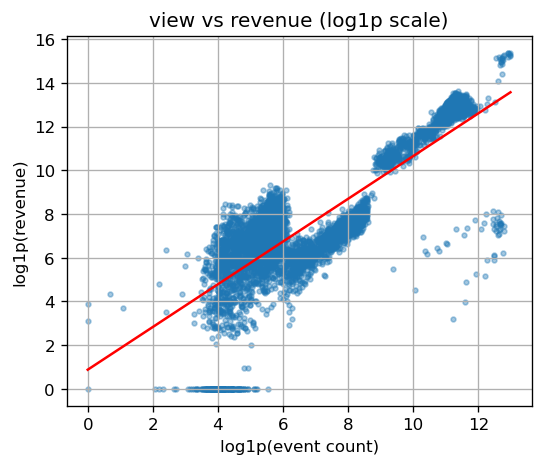

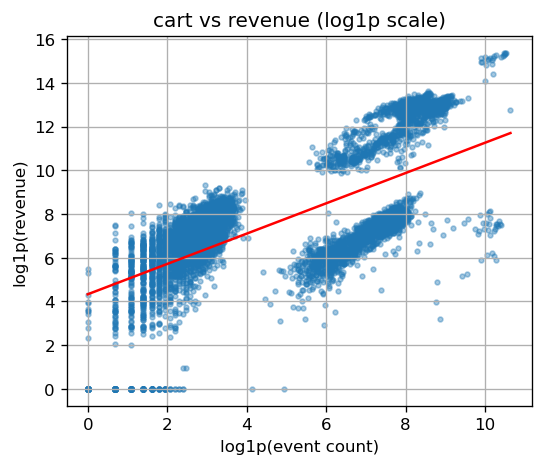

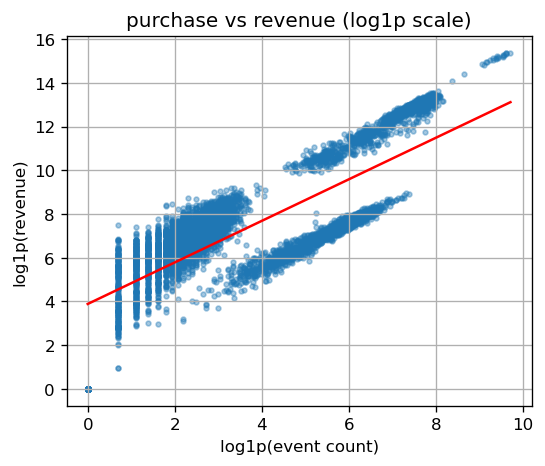

In [14]:

def scatter_with_fit(x, y, title):
    x_log, y_log = np.log1p(x), np.log1p(y)
    k, b = np.polyfit(x_log, y_log, 1)
    xfit = np.linspace(x_log.min(), x_log.max(), 100)
    yfit = k*xfit + b

    plt.figure(figsize=(5,4))
    plt.scatter(x_log, y_log, s=8, alpha=0.4)
    plt.plot(xfit, yfit, color="red")
    plt.title(title + " (log1p scale)")
    plt.xlabel("log1p(event count)")
    plt.ylabel("log1p(revenue)")
    plt.grid(True)
    plt.show()

for ev in ["view","cart","purchase"]:
    scatter_with_fit(hour_df[ev].values, hour_df["revenue"].values, f"{ev} vs revenue")


Relationship Between Event Counts and Revenue (log1p scale)

1. View vs Revenue
- **Strong positive relationship**: Higher view counts generally correspond to higher revenue.
- Regression line shows a clear upward slope, confirming that browsing activity is a good predictor of sales.
- Distinct clusters suggest different traffic/revenue regimes.
- Outliers indicate cases where high views did not result in proportional revenue, implying potential conversion issues.

2. Cart vs Revenue
- Positive correlation, but the slope is **less steep** than for views, suggesting that cart additions alone are not as strong a driver as purchases.
- Clustering patterns similar to views, indicating shared underlying behavior.
- Presence of zero-revenue points even at nonzero cart counts suggests abandoned carts or failed checkouts.

3. Purchase vs Revenue
- **Strongest and most direct relationship** with revenue among the three metrics.
- Regression line aligns closely with the main data clusters, indicating purchases are the most reliable predictor of revenue.
- Minimal deviation from trend compared to views and carts.

Overall Insight:**
- All three event types show a positive relationship with revenue, but **purchase count** is the strongest predictor, followed by **view count**.
- Cart events provide useful but less direct predictive power, as not all carts convert.
- Improving **conversion from views to carts and from carts to purchases** could significantly increase revenue efficiency.
